In [1]:
import os
import typing
import random
import castle.algorithms
import joblib
import networkx as nx
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import utils 

# keep me, I am needed by castle
import torch
import matplotlib.pyplot as plt

2024-10-16 11:28:19,638 - e:\Softwares\Anaconda\CondaEnvs\casual\lib\site-packages\castle\backend\__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2024-10-16 11:28:19,863 - e:\Softwares\Anaconda\CondaEnvs\casual\lib\site-packages\castle\algorithms\__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.
e:\Softwares\Anaconda\CondaEnvs\casual\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X_train = pd.read_pickle('data/X_train.pickle')
X_test = pd.read_pickle('data/X_test.pickle')
y_train = pd.read_pickle('data/y_train.pickle')
y_test = pd.read_pickle('data/y_test.pickle')

In [3]:
X_train['00000']

,0,Y,2,3,4,5,6,7,8,X
0,0.311,-0.365,0.327,0.383,-0.519,-0.015,-0.713,0.183,0.515,0.951
1,0.125,0.657,-0.097,-0.341,-0.807,-0.527,-0.027,0.711,0.591,-0.515
2,0.499,-0.307,-0.395,0.067,0.761,-0.147,-0.501,0.015,0.267,0.109
3,-0.337,-0.105,0.455,0.267,-0.091,0.427,0.037,-0.221,-0.455,0.157
4,-0.139,-0.691,-0.287,-0.383,-0.899,0.415,0.899,-0.771,-0.593,-0.049
...,...,...,...,...,...,...,...,...,...,...
995,-0.965,0.853,-0.187,0.319,-0.841,0.281,0.795,0.599,0.245,-0.931
996,0.323,0.851,0.775,-0.187,0.361,-0.681,-0.307,0.351,0.433,-0.829
997,0.795,0.409,-0.629,-0.879,0.035,-0.761,0.301,0.355,0.941,0.363
998,0.855,-0.721,0.193,-0.025,0.485,-0.351,-0.799,-0.007,-0.329,0.715


In [4]:
y_train['00000']


,0,Y,2,3,4,5,6,7,8,X
parent,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0
Y,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0
3,0,1,0,0,0,1,0,0,0,0
4,0,1,0,0,0,1,0,0,0,0
5,1,1,0,0,0,0,0,0,0,0
6,0,1,0,0,0,1,0,0,0,0
7,0,1,0,0,0,1,0,0,0,0
8,0,0,1,1,0,0,0,1,0,1


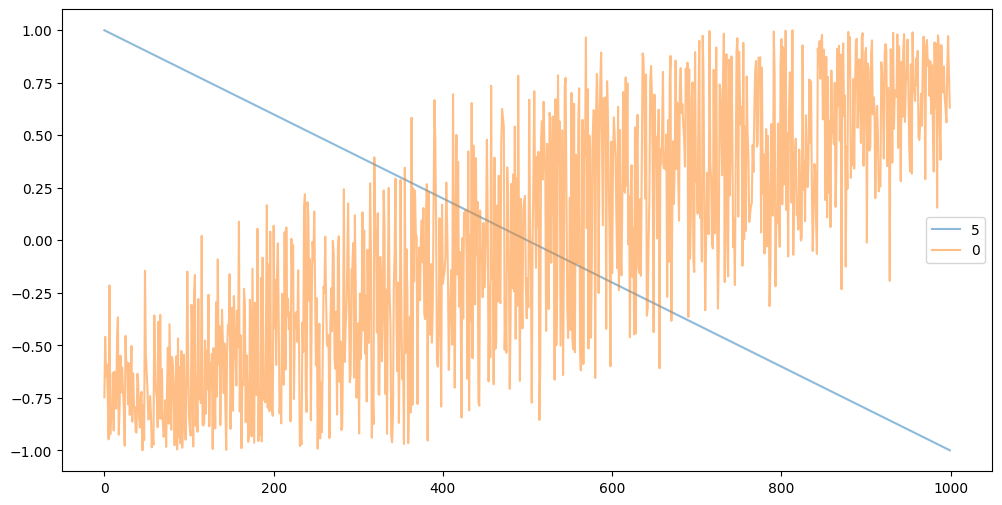

In [5]:
# 可视化，探索是否有时序关系

test_key = '00000'

# sort by value of 0 and plot again
X_train_sorted = X_train[test_key].sort_values(by='5', ascending=False)
#reset index
X_train_sorted = X_train_sorted.reset_index()


plt.figure(figsize=(12, 6))
plt.plot(X_train_sorted['5'], label='5', alpha=0.5)
plt.plot(X_train_sorted['0'], label='0', alpha=0.5)
# plt.plot(X_test_sorted['Y'], label='Y')
plt.legend()
plt.show()


In [6]:
# import pandas as pd
# import random

# def apply_mapping(df, mapping):
#     df_new = df.copy()
#     # 创建临时映射以避免冲突
#     temp_mapping = {k: f'_temp_{k}' for k in mapping.keys()}
#     df_new.rename(columns=temp_mapping, inplace=True)
#     if df_new.shape[0] == df_new.shape[1]:  # 如果是方阵，如标签矩阵
#         df_new.rename(index=temp_mapping, inplace=True)
#     # 应用最终映射
#     final_mapping = {f'_temp_{k}': v for k, v in mapping.items()}
#     df_new.rename(columns=final_mapping, inplace=True)
#     if df_new.shape[0] == df_new.shape[1]:
#         df_new.rename(index=final_mapping, inplace=True)
#     return df_new

# def augment_data(X_train, y_train):
#     new_X_train = X_train.copy()
#     new_y_train = y_train.copy()
#     for sample_id in tqdm(X_train.keys(), desc="Augmenting data"):
#         X = X_train[sample_id]
#         y = y_train[sample_id]
#         variables = list(X.columns)
#         dim = len(variables)
#         # 提取因果关系对
#         edges = []
#         for u in y.index:
#             for v in y.columns:
#                 if y.loc[u, v] == 1:
#                     edges.append((u, v))
#         # 根据维度筛选因果关系对
#         if dim >= 4:
#             edges_filtered = edges
#         else:
#             edges_filtered = edges
#         if not edges_filtered:
#             continue  # 如果没有找到合适的因果关系，跳过
#         # 随机选择一对因果关系
#         u, v = random.choice(edges_filtered)
#         mapping = {'X': u, 'Y': v, u: 'X', v: 'Y'}
#         # 应用映射到特征矩阵和标签矩阵
#         X_new = apply_mapping(X, mapping)
#         y_new = apply_mapping(y, mapping)
#         # 存储新的数据
#         new_sample_id = '0' + sample_id
#         new_X_train[new_sample_id] = X_new
#         new_y_train[new_sample_id] = y_new
#     return new_X_train, new_y_train

# # 使用示例
# new_X_train, new_y_train = augment_data(X_train, y_train)


In [25]:
import math
import random
import pandas as pd

def apply_mapping(df, mapping):
    df_new = df.copy()
    # 获取所有需要重命名的列名，包括映射中的值（避免冲突）
    all_columns = set(df_new.columns)
    all_indices = set(df_new.index)
    mapping_values = set(mapping.values())

    # 检查是否有名称冲突
    conflict_columns = all_columns.intersection(mapping_values)
    conflict_indices = all_indices.intersection(mapping_values)

    # 创建临时映射以避免冲突
    temp_mapping = {}
    for k in mapping.keys():
        if k in conflict_columns or k in conflict_indices:
            temp_name = f'_temp_{k}'
            temp_mapping[k] = temp_name
        else:
            temp_mapping[k] = k

    df_new.rename(columns=temp_mapping, inplace=True)
    if set(df_new.index) == set(df_new.columns):  # 如果是方阵，如标签矩阵
        df_new.rename(index=temp_mapping, inplace=True)

    # 应用最终映射
    final_mapping = {temp_mapping[k]: mapping[k] for k in mapping.keys()}
    df_new.rename(columns=final_mapping, inplace=True)
    if set(df_new.index) == set(df_new.columns):
        df_new.rename(index=final_mapping, inplace=True)

    return df_new

def check_duplicate_columns(df):
    """检查是否存在重复的列名"""
    return df.columns.duplicated().any()

def augment_data(X_train, y_train, augment_factor=1.5):
    """
    扩增数据集。

    参数:
    - X_train: dict, 原始特征矩阵，键为样本ID，值为DataFrame
    - y_train: dict, 原始标签矩阵，键为样本ID，值为DataFrame
    - augment_factor: float, 数据扩增的倍数，例如2.5表示每个样本生成2到3个增强样本
    """
    new_X_train = X_train.copy()
    new_y_train = y_train.copy()
    failure_counts = {dim: 0 for dim in range(3, 11)}  # 初始化失败计数器

    for sample_id in X_train.keys():
        X = X_train[sample_id]
        y = y_train[sample_id]
        variables = list(X.columns)
        dim = len(variables)
        # 提取因果关系对
        edges = []
        for u in y.index:
            for v in y.columns:
                if y.loc[u, v] == 1:
                    edges.append((u, v))

        # 计算每个样本需要生成的增强样本数量
        integer_part = math.floor(augment_factor)
        fractional_part = augment_factor - integer_part

        for augment_num in range(integer_part):
            edges_to_use = edges.copy()

            if not edges_to_use:
                # 没有边可用，计数失败次数
                failure_counts[dim] += 1
                continue

            attempts = 0
            success = False
            while attempts < 3 and not success:
                if not edges_to_use:
                    break  # 没有合适的边，跳出循环
                edges_to_use.remove(('X', 'Y'))
                u, v = random.choice(edges_to_use)
                mapping = {u: 'X', v: 'Y', 'X': u, 'Y': v}
                # 应用映射到特征矩阵和标签矩阵
                X_new = apply_mapping(X, mapping)
                y_new = apply_mapping(y, mapping)
                # 检查特征矩阵是否有重复列
                if check_duplicate_columns(X_new):
                    attempts += 1
                    edges_to_use.remove((u, v))  # 移除当前选择，避免重复尝试
                    print('duplicate columns')
                    continue  # 重试
                elif mapping == {'X': 'X', 'Y': 'Y'}:
                    print('mapping is the same')
                    continue
                else:
                    # 没有重复列，存储新的数据
                    new_sample_id = f'{augment_num}{sample_id}'
                    new_X_train[new_sample_id] = X_new
                    new_y_train[new_sample_id] = y_new
                    success = True
            if not success:
                # 计数失败次数
                failure_counts[dim] += 1

        # 处理小数部分
        if fractional_part > 0:
            if random.random() < fractional_part:
                augment_num = integer_part
                edges_to_use = edges.copy()

                if not edges_to_use:
                    failure_counts[dim] += 1
                else:
                    edges_to_use.remove(('X', 'Y'))
                    attempts = 0
                    success = False
                    while attempts < 3 and not success:
                        if not edges_to_use:
                            break  # 没有合适的边，跳出循环
                        u, v = random.choice(edges_to_use)
                        mapping = {u: 'X', v: 'Y', 'X': u, 'Y': v}
                        print(mapping)
                        # 应用映射到特征矩阵和标签矩阵
                        X_new = apply_mapping(X, mapping)
                        y_new = apply_mapping(y, mapping)
                        # 检查特征矩阵是否有重复列
                        if check_duplicate_columns(X_new):
                            attempts += 1
                            edges_to_use.remove((u, v))  # 移除当前选择，避免重复尝试
                            print(y_new)
                            print(y)
                            print('-' *  20)
                            continue  # 重试
                        else:
                            # 没有重复列，存储新的数据
                            new_sample_id = f'{augment_num}{sample_id}'
                            new_X_train[new_sample_id] = X_new
                            new_y_train[new_sample_id] = y_new
                            success = True
                    if not success:
                        # 计数失败次数
                        # 展示失败的数据
                        failure_counts[dim] += 1

    return new_X_train, new_y_train, failure_counts


In [26]:
new_X_train, new_y_train, failure_counts = augment_data(X_train, y_train, augment_factor=0.1)

print("增强后的样本数量：", len(new_X_train))
print("增强失败的次数：", failure_counts)


{'Y': '7', '7': 'Y', 'X': 'Y'}
        0  1  2  3  4  5  7  Y  8  Y
parent                              
0       0  0  1  0  0  0  1  0  0  0
1       0  0  0  0  0  0  1  0  0  0
2       0  0  0  0  0  0  0  0  1  0
3       0  0  1  0  0  1  1  0  0  0
4       0  0  0  0  0  0  0  0  0  0
5       0  0  0  0  1  0  0  0  1  0
Y       0  0  0  0  0  0  0  1  0  0
7       0  0  0  0  0  0  0  0  0  0
8       0  0  0  0  1  0  0  0  0  0
X       0  0  0  0  0  1  1  0  0  0
        0  1  2  3  4  5  Y  7  8  X
parent                              
0       0  0  1  0  0  0  1  0  0  0
1       0  0  0  0  0  0  1  0  0  0
2       0  0  0  0  0  0  0  0  1  0
3       0  0  1  0  0  1  1  0  0  0
4       0  0  0  0  0  0  0  0  0  0
5       0  0  0  0  1  0  0  0  1  0
Y       0  0  0  0  0  0  0  1  0  0
7       0  0  0  0  0  0  0  0  0  0
8       0  0  0  0  1  0  0  0  0  0
X       0  0  0  0  0  1  1  0  0  0
--------------------
{'5': 'X', '4': 'Y', 'X': '5', 'Y': '4'}
{'X': 'X', '2': 'Y'

In [14]:
display(y_train['00007'])
display(new_y_train['100007'])

,0,1,2,3,4,5,Y,7,8,X
parent,,,,,,,,,,
0,0,0,1,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,1,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,1,0
Y,0,0,0,0,0,0,0,1,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,1,0,0,0,0,0


,0,1,2,3,4,5,Y,7,8,X
parent,,,,,,,,,,
0,0,0,1,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,1,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,1,0
Y,0,0,0,0,0,0,0,1,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,1,0,0,0,0,0


In [8]:
new_X_train['000007']

,0,1,2,3,4,5,Y,7,8,X
0,-0.789,-0.357,0.071,0.509,-0.603,-0.861,0.617,0.559,0.999,0.671
1,0.851,0.539,0.491,0.827,0.049,0.013,-0.007,-0.667,-0.127,-0.673
2,-0.777,-0.869,-0.965,-0.877,0.025,0.837,0.657,-0.069,-0.927,-0.477
3,-0.955,0.381,-0.293,0.239,-0.629,-0.511,0.065,-0.479,0.157,0.523
4,-0.881,0.337,-0.653,-0.203,-0.521,-0.493,0.193,-0.439,-0.469,0.729
...,...,...,...,...,...,...,...,...,...,...
995,-0.035,-0.873,0.637,0.493,0.887,0.375,0.687,-0.661,0.127,-0.729
996,-0.229,0.467,-0.435,-0.399,0.839,0.795,0.075,-0.927,-0.465,-0.593
997,0.149,-0.037,0.985,0.515,0.491,0.427,0.549,-0.361,0.061,-0.769
998,0.175,-0.085,0.563,0.377,-0.601,-0.417,-0.257,0.765,0.241,0.251


In [49]:
import math
import random
import pandas as pd

def apply_mapping(df, mapping, rename_index=False):
    df_new = df.copy()
    # 创建临时映射以避免冲突
    temp_mapping = {k: f'_temp_{k}' for k in mapping.keys()}
    df_new.rename(columns=temp_mapping, inplace=True)
    if rename_index:
        df_new.rename(index=temp_mapping, inplace=True)
    # 应用最终映射
    final_mapping = {temp_mapping[k]: mapping[k] for k in mapping.keys()}
    df_new.rename(columns=final_mapping, inplace=True)
    if rename_index:
        df_new.rename(index=final_mapping, inplace=True)
    return df_new

def check_duplicate_columns(df):
    """检查是否存在重复的列名"""
    return df.columns.duplicated().any()

def augment_data(X_train, y_train, augment_factor=1.5):
    """
    扩增数据集。

    参数:
    - X_train: dict, 原始特征矩阵，键为样本ID，值为DataFrame
    - y_train: dict, 原始标签矩阵，键为样本ID，值为DataFrame
    - augment_factor: float, 数据扩增的倍数，例如2.5表示每个样本生成2到3个增强样本
    """
    new_X_train = X_train.copy()
    new_y_train = y_train.copy()
    failure_counts = {dim: 0 for dim in range(3, 11)}  # 初始化失败计数器

    for sample_id in X_train.keys():
        X = X_train[sample_id]
        y = y_train[sample_id]
        variables = list(map(str, X.columns))
        dim = len(variables)

        # 将变量名都转换为字符串类型
        X.columns = X.columns.astype(str)
        if set(X.index) == set(X.columns):
            X.index = X.index.astype(str)
        y.columns = y.columns.astype(str)
        y.index = y.index.astype(str)

        # 第一步：将 'X' 和 'Y' 重命名为未使用的数字
        used_variables = set(X.columns) | set(y.index) | set(y.columns)
        all_numbers = set(map(str, range(10)))  # '0' 到 '9' 的字符串集合
        unused_numbers = list(all_numbers - used_variables)

        mapping_XY = {}
        if 'X' in used_variables:
            if unused_numbers:
                new_X_name = unused_numbers.pop()
                mapping_XY['X'] = new_X_name
            else:
                # 没有未使用的数字，无法重命名 'X'
                failure_counts[dim] += 1
                continue  # 跳过此样本
        if 'Y' in used_variables:
            if unused_numbers:
                new_Y_name = unused_numbers.pop()
                mapping_XY['Y'] = new_Y_name
            else:
                # 没有未使用的数字，无法重命名 'Y'
                failure_counts[dim] += 1
                continue  # 跳过此样本
        if mapping_XY:
            X = X.rename(columns=mapping_XY)
            if set(X.index) == set(X.columns):
                X = X.rename(index=mapping_XY)
            y = y.rename(index=mapping_XY, columns=mapping_XY)
            # 更新变量名
            variables = list(X.columns)

        # 重新提取因果关系对
        edges = []
        for u in y.index:
            for v in y.columns:
                if y.loc[u, v] == 1:
                    edges.append((u, v))

        # 计算每个样本需要生成的增强样本数量
        integer_part = math.floor(augment_factor)
        fractional_part = augment_factor - integer_part
        edges_to_use = edges.copy()
        
        edges_to_use.remove((mapping_XY['X'], mapping_XY['Y']))
        for augment_num in range(integer_part):
            
            # 移除之前映射的 (X, Y)

            if not edges_to_use:
                # 没有边可用，计数失败次数
                failure_counts[dim] += 1
                continue

            attempts = 0
            success = False
            while attempts < 3 and not success:
                if not edges_to_use:
                    break  # 没有合适的边，跳出循环
                u, v = random.choice(edges_to_use)
                edges_to_use.remove((u, v))
                mapping = {u: 'X', v: 'Y'}
                # 应用映射到特征矩阵和标签矩阵
                X_new = apply_mapping(X, mapping)
                y_new = apply_mapping(y, mapping, rename_index=True)
                # 检查特征矩阵是否有重复列
                if check_duplicate_columns(X_new):
                    attempts += 1
                    continue  # 重试
                else:
                    # 没有重复列，存储新的数据
                    new_sample_id = f'{augment_num}{sample_id}'
                    new_X_train[new_sample_id] = X_new
                    new_y_train[new_sample_id] = y_new
                    success = True
            if not success:
                # 计数失败次数
                failure_counts[dim] += 1

        # 处理小数部分
        if fractional_part > 0:
            if random.random() < fractional_part:
                augment_num = integer_part
                if not edges_to_use:
                    failure_counts[dim] += 1
                else:
                    attempts = 0
                    success = False
                    while attempts < 3 and not success:
                        if not edges_to_use:
                            break  # 没有合适的边，跳出循环
                        u, v = random.choice(edges_to_use)
                        edges_to_use.remove((u, v))
                        mapping = {u: 'X', v: 'Y'}
                        # 应用映射到特征矩阵和标签矩阵
                        X_new = apply_mapping(X, mapping)
                        y_new = apply_mapping(y, mapping, rename_index=True)
                        # 检查特征矩阵是否有重复列
                        if check_duplicate_columns(X_new):
                            attempts += 1
                            continue  # 重试
                        else:
                            # 没有重复列，存储新的数据
                            new_sample_id = f'{augment_num}{sample_id}'
                            new_X_train[new_sample_id] = X_new
                            new_y_train[new_sample_id] = y_new
                            success = True
                    if not success:
                        # 计数失败次数
                        failure_counts[dim] += 1

    return new_X_train, new_y_train, failure_counts


In [50]:
new_X_train, new_y_train, failure_counts = augment_data(X_train, y_train, augment_factor=3)
print("增强后的样本数量：", len(new_X_train))
print("增强失败的次数：", failure_counts)

增强后的样本数量： 92247
增强失败的次数： {3: 1605, 4: 146, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 2}


In [51]:

display(y_train['00024'])
display(new_y_train['000024'])
display(new_y_train['100024'])
display(new_y_train['200024'])

,0,1,Y,3,X,5,6,7
parent,,,,,,,,
0,0,0,0,1,0,0,1,0
1,1,0,1,0,0,1,0,0
Y,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0
X,0,0,1,0,0,0,0,0
5,0,0,0,1,0,0,0,0
6,0,0,0,1,0,0,0,0
7,0,0,0,0,0,1,0,0


,0,X,Y,3,9,5,6,7
parent,,,,,,,,
0,0,0,0,1,0,0,1,0
X,1,0,1,0,0,1,0,0
Y,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0
9,0,0,1,0,0,0,0,0
5,0,0,0,1,0,0,0,0
6,0,0,0,1,0,0,0,0
7,0,0,0,0,0,1,0,0


,0,X,4,3,9,Y,6,7
parent,,,,,,,,
0,0,0,0,1,0,0,1,0
X,1,0,1,0,0,1,0,0
4,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0
9,0,0,1,0,0,0,0,0
Y,0,0,0,1,0,0,0,0
6,0,0,0,1,0,0,0,0
7,0,0,0,0,0,1,0,0


,Y,X,4,3,9,5,6,7
parent,,,,,,,,
Y,0,0,0,1,0,0,1,0
X,1,0,1,0,0,1,0,0
4,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0
9,0,0,1,0,0,0,0,0
5,0,0,0,1,0,0,0,0
6,0,0,0,1,0,0,0,0
7,0,0,0,0,0,1,0,0


In [52]:

display(X_train['00024'])
display(new_X_train['000024'])
display(new_X_train['100024'])


,0,1,Y,3,X,5,6,7
0,0.209,-0.743,-0.573,-0.519,-0.777,0.511,-0.855,0.415
1,0.733,-0.143,0.485,0.319,0.221,-0.891,0.105,-0.881
2,0.849,-0.223,0.169,0.033,0.115,0.227,0.135,0.819
3,-0.231,0.177,0.155,0.779,0.063,-0.871,0.159,-0.867
4,0.353,-0.057,-0.565,-0.245,-0.587,-0.145,-0.779,0.017
...,...,...,...,...,...,...,...,...
995,0.939,-0.657,-0.389,0.053,-0.557,-0.411,-0.619,-0.179
996,0.541,-0.227,0.085,0.477,-0.041,-0.149,0.521,0.685
997,-0.185,0.825,0.447,-0.209,0.521,0.803,0.473,0.035
998,0.271,-0.141,-0.185,0.405,-0.211,-0.657,-0.245,-0.605


,0,X,Y,3,9,5,6,7
0,0.209,-0.743,-0.573,-0.519,-0.777,0.511,-0.855,0.415
1,0.733,-0.143,0.485,0.319,0.221,-0.891,0.105,-0.881
2,0.849,-0.223,0.169,0.033,0.115,0.227,0.135,0.819
3,-0.231,0.177,0.155,0.779,0.063,-0.871,0.159,-0.867
4,0.353,-0.057,-0.565,-0.245,-0.587,-0.145,-0.779,0.017
...,...,...,...,...,...,...,...,...
995,0.939,-0.657,-0.389,0.053,-0.557,-0.411,-0.619,-0.179
996,0.541,-0.227,0.085,0.477,-0.041,-0.149,0.521,0.685
997,-0.185,0.825,0.447,-0.209,0.521,0.803,0.473,0.035
998,0.271,-0.141,-0.185,0.405,-0.211,-0.657,-0.245,-0.605


,0,X,4,3,9,Y,6,7
0,0.209,-0.743,-0.573,-0.519,-0.777,0.511,-0.855,0.415
1,0.733,-0.143,0.485,0.319,0.221,-0.891,0.105,-0.881
2,0.849,-0.223,0.169,0.033,0.115,0.227,0.135,0.819
3,-0.231,0.177,0.155,0.779,0.063,-0.871,0.159,-0.867
4,0.353,-0.057,-0.565,-0.245,-0.587,-0.145,-0.779,0.017
...,...,...,...,...,...,...,...,...
995,0.939,-0.657,-0.389,0.053,-0.557,-0.411,-0.619,-0.179
996,0.541,-0.227,0.085,0.477,-0.041,-0.149,0.521,0.685
997,-0.185,0.825,0.447,-0.209,0.521,0.803,0.473,0.035
998,0.271,-0.141,-0.185,0.405,-0.211,-0.657,-0.245,-0.605


In [33]:
new_y_train.keys()

dict_keys(['00000', '00002', '00007', '00009', '00011', '00016', '00017', '00018', '00024', '00028', '00030', '00038', '00039', '00041', '00043', '00044', '00045', '00047', '00048', '00050', '00053', '00054', '00056', '00059', '00060', '00061', '00065', '00067', '00069', '00070', '00073', '00074', '00076', '00080', '00081', '00082', '00083', '00084', '00086', '00088', '00091', '00093', '00096', '00098', '00100', '00101', '00103', '00105', '00106', '00108', '00109', '00111', '00112', '00114', '00115', '00119', '00123', '00125', '00128', '00129', '00135', '00136', '00138', '00140', '00141', '00142', '00143', '00144', '00145', '00147', '00148', '00149', '00151', '00152', '00153', '00157', '00158', '00159', '00161', '00162', '00166', '00167', '00168', '00169', '00171', '00176', '00177', '00187', '00188', '00190', '00191', '00195', '00196', '00199', '00204', '00207', '00208', '00210', '00212', '00215', '00217', '00222', '00223', '00226', '00228', '00229', '00230', '00232', '00233', '00237',